### 0. Imports and Formatters

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import fractions
from IPython import get_ipython
from typing import Tuple, Callable, Any

def make_frac_formatter(width: int = 16,
                        max_sqrt: int = 50,
                        tol: float = 1e-10,
                        max_den: int = 1000,
                        max_den_search: int = 100) -> Tuple[Callable, Callable]:
    """Return two formatters:
       - core_repr(x) -> unpadded string representation
       - _fmt_array(x) -> right-justified (for numpy array element printing)
       - _fmt_scalar(x) -> left-justified (for standalone scalar display)
    """
    def _core_repr(val: Any) -> str:
        # handle non-scalar quickly
        try:
            re_val = float(np.real(val))
            im_val = float(np.imag(val))
        except Exception:
            return str(val)

        def _sqrt_rep(v: float) -> str:
            if abs(v) < tol:
                return "0"
            frac = fractions.Fraction(v).limit_denominator(max_den)
            if abs(float(frac) - v) < tol:
                return str(frac)

            # pure coeff * sqrt(n)
            for n in range(2, max_sqrt + 1):
                r = v / np.sqrt(n)
                fr = fractions.Fraction(r).limit_denominator(max_den)
                if abs(float(fr) - r) < 1e-8:
                    if fr.denominator == 1:
                        coeff = str(fr.numerator)
                    else:
                        coeff = f"{fr.numerator}/{fr.denominator}"
                    return f"{coeff}*sqrt({n})"

            # try (a + b*sqrt(n))/D
            for n in range(2, max_sqrt + 1):
                sqrt_n = np.sqrt(n)
                for D in range(1, max_den_search + 1):
                    rD = v * D
                    base = int(np.floor(rD))
                    for a in range(base - 3, base + 4):
                        b_float = (rD - a) / sqrt_n
                        b_frac = fractions.Fraction(b_float).limit_denominator(max_den)
                        if abs(float(b_frac) - b_float) < tol:
                            p = b_frac.numerator
                            q = b_frac.denominator
                            A = a * q
                            P = p
                            Den = D * q
                            g = abs(np.gcd(A, np.gcd(P, Den)))
                            if g > 1:
                                A //= g
                                P //= g
                                Den //= g

                            parts = []
                            if A != 0:
                                parts.append(str(A))
                            if P != 0:
                                p_str = "" if abs(P) == 1 else str(abs(P)) + "*"
                                sqrt_part = f"{p_str}sqrt({n})"
                                if P < 0:
                                    sqrt_part = "-" + sqrt_part
                                parts.append(sqrt_part)

                            if not parts:
                                numer = "0"
                            else:
                                if len(parts) == 1:
                                    numer = parts[0]
                                else:
                                    sep = "" if parts[1].startswith("-") else "+"
                                    numer = f"{parts[0]}{sep}{parts[1]}"
                            if Den == 1:
                                return numer
                            return f"({numer})/{Den}"

            return str(fractions.Fraction(v).limit_denominator(max_den))

        # build final string for complex/real
        if abs(im_val) < tol:
            return _sqrt_rep(re_val)
        if abs(re_val) < tol:
            return f"{_sqrt_rep(im_val)}j"
        a = _sqrt_rep(re_val)
        b = _sqrt_rep(abs(im_val))
        sign = "+" if im_val >= 0 else "-"
        return f"{a}{sign}{b}j"

    # array element formatter: right-justified
    def _fmt_array(x: Any) -> str:
        # numpy passes scalar elements here, but if whole arrays slip through, format them simply
        if isinstance(x, (np.ndarray, list, tuple)):
            return str(x).rjust(width)
        return _core_repr(x).rjust(width)

    # scalar display formatter: left-justified
    def _fmt_scalar(x: Any) -> str:
        if isinstance(x, (np.ndarray, list, tuple)):
            return str(x).ljust(width)
        return _core_repr(x).ljust(width)

    # return both so caller can register appropriately
    return _fmt_array, _fmt_scalar

# install formatters
_fmt_array, _fmt_scalar = make_frac_formatter(width=16)
np.set_printoptions(linewidth=1000)
np.set_printoptions(formatter={'all': _fmt_array})

_ip = get_ipython()
if _ip is not None:
    plain = _ip.display_formatter.formatters['text/plain']
    def _ip_fmt(obj, p, cycle):
        # IPython expects us to write to p.text
        p.text(_fmt_scalar(obj))
    plain.for_type(np.complex128, _ip_fmt)
    plain.for_type(np.float64,    _ip_fmt)
    plain.for_type(np.int64,      _ip_fmt)
    plain.for_type(complex,       _ip_fmt)
    plain.for_type(float,         _ip_fmt)
    plain.for_type(int,           _ip_fmt)

### 1. Density matrix

In [12]:
p_0 = 0.5
psi_1 = np.array([1, 1j, -1, 0, 2]) / np.sqrt(7)
psi_2 = np.array([1, 1, 1, 1, 1]) / np.sqrt(5)
rho = p_0 * np.outer(psi_1, np.conj(psi_1)) + (1 - p_0) * np.outer(psi_2, np.conj(psi_2))
rho

array([[            6/35,       1/10-1/14j,             1/35,             1/10,            17/70],
       [      1/10+1/14j,             6/35,       1/10-1/14j,             1/10,        1/10+1/7j],
       [            1/35,       1/10+1/14j,             6/35,             1/10,            -3/70],
       [            1/10,             1/10,             1/10,             1/10,             1/10],
       [           17/70,        1/10-1/7j,            -3/70,             1/10,            27/70]])

### 2. Trace

In [13]:
np.trace(rho)

1               

In [14]:
np.trace(rho @ rho)

4/7             

In [15]:
H = np.diag([j * (j - 1) for j in range(5)])
np.trace(H @ rho)

39/7            

### 3. Eigenvalues

In [16]:
p_k = np.linalg.eigvals(rho)
p_k

array([  (7+sqrt(7))/14,                0,   (7-sqrt(7))/14,                0,                0])

In [17]:
S = -np.sum(p_k * np.log(p_k))
print(f"{np.real_if_close(S):.4f}")

0.6199


### 4. Canonical Density matrix

In [18]:
def rho_k(T):
    exp = np.exp(-H / T)
    Z = np.trace(exp)
    return exp / Z

def E(T):
    rho = rho_k(T)
    return np.trace(H @ rho)

def S(T):
    rho = rho_k(T)
    return -np.trace(rho @ np.log(rho))

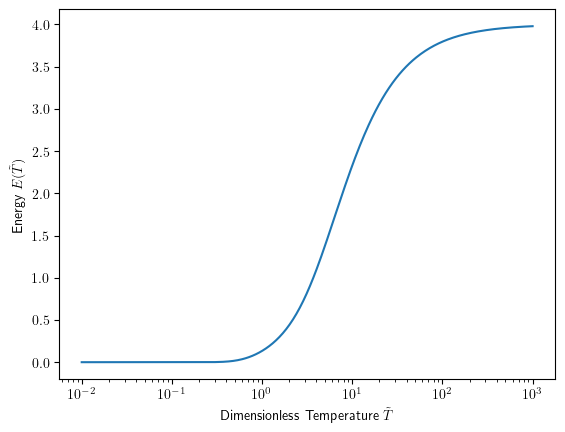

In [19]:
T = np.logspace(-2, 3, 400)
E_vals = np.array([E(t) for t in T])
plt.plot(T, E_vals)
plt.xscale('log')
plt.xlabel(r"Dimensionless Temperature $\tilde{T}$")
plt.ylabel(r"Energy $E(\tilde{T})$")
plt.show()

C:\Users\nicol\AppData\Local\Temp\ipykernel_27956\1283499653.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.trace(rho @ np.log(rho))
C:\Users\nicol\AppData\Local\Temp\ipykernel_27956\1283499653.py:12: RuntimeWarning: invalid value encountered in matmul
  return -np.trace(rho @ np.log(rho))


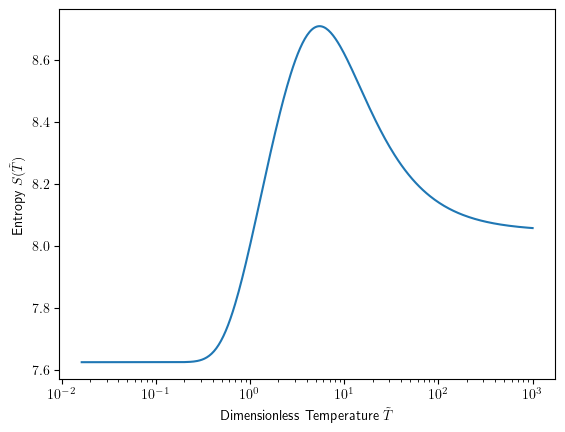

In [20]:
T = np.logspace(-2, 3, 400)
S_vals = np.array([S(t) for t in T])
plt.plot(T, S_vals)
plt.xscale('log')
plt.xlabel(r"Dimensionless Temperature $\tilde{T}$")
plt.ylabel(r"Entropy $S(\tilde{T})$")
plt.show()

In [2]:
import ipywidgets as widgets
out = widgets.Output(layout={'border': '1px solid black'})
with out:
    for i in range(10):
        print(i, 'Hello world!')

ModuleNotFoundError: No module named 'ipywidgets'